# ANN model construct 2

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.layers import Dense, Activation, BatchNormalization, Dropout
from keras import regularizers
from keras.optimizers import RMSprop, Adam, SGD
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


columns_to_include = list(range(10))  # This creates a list of integers from 0 to 9
dataset = pd.read_csv('combined_data.csv', delimiter=';', usecols=columns_to_include)

dataset['Timestamp'] = pd.to_datetime(dataset['Timestamp'], format='%Y/%m/%d %H:%M')

In [3]:
dataset2 = dataset
dataset2.head()

,Timestamp,Module Temperature,Irradiance,Temperature,Humidity,Pressure,Wind Speed,Wind Direction,Rain,PV yield counter
0,2022-09-10 00:00:00,12.500,7.500,13.7,89.0,1001.4,1.4,330.0,0.0,0.0
1,2022-09-10 01:00:00,12.775,7.528,13.0,90.0,1000.8,1.7,350.0,0.0,0.0
2,2022-09-10 02:00:00,12.262,9.034,13.2,92.0,1000.3,1.4,350.0,0.0,0.0
3,2022-09-10 03:00:00,11.972,9.034,10.2,94.0,999.7,1.4,330.0,0.0,0.0
4,2022-09-10 04:00:00,11.810,8.281,10.7,95.0,999.8,1.7,300.0,0.0,0.0


In [4]:
dataset = dataset.iloc[:, 1:]  # Exclude the first column (index 0)

# Separate the data into features (X) and target variable (y)
X = dataset.iloc[:, :-1].values  # Select all columns except the last one as features
y = dataset.iloc[:, -1].values   # Select the last column as the target variable


print("Features (X):")
print(X[:5]) 
print("Target Variable (y):")
print(y[:5])  


print("Original Shapes - X:", X.shape, "y:", y.shape)

y = np.reshape(y, (-1,1))
print("Reshaped Shapes - X:", X.shape, "y:", y.shape)

Features (X):
[[  12.5      7.5     13.7     89.    1001.4      1.4    330.       0.   ]
 [  12.775    7.528   13.      90.    1000.8      1.7    350.       0.   ]
 [  12.262    9.034   13.2     92.    1000.3      1.4    350.       0.   ]
 [  11.972    9.034   10.2     94.     999.7      1.4    330.       0.   ]
 [  11.81     8.281   10.7     95.     999.8      1.7    300.       0.   ]]
Target Variable (y):
[0. 0. 0. 0. 0.]
Original Shapes - X: (8677, 8) y: (8677,)
Reshaped Shapes - X: (8677, 8) y: (8677, 1)


In [5]:
dataset.head()

,Module Temperature,Irradiance,Temperature,Humidity,Pressure,Wind Speed,Wind Direction,Rain,PV yield counter
0,12.500,7.500,13.7,89.0,1001.4,1.4,330.0,0.0,0.0
1,12.775,7.528,13.0,90.0,1000.8,1.7,350.0,0.0,0.0
2,12.262,9.034,13.2,92.0,1000.3,1.4,350.0,0.0,0.0
3,11.972,9.034,10.2,94.0,999.7,1.4,330.0,0.0,0.0
4,11.810,8.281,10.7,95.0,999.8,1.7,300.0,0.0,0.0


# Splitting and training dataset

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print("Train Shape: {} {} \nTest Shape: {} {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

Train Shape: (6507, 8) (6507, 1) 
Test Shape: (2170, 8) (2170, 1)


In [7]:
#dataset['Timestamp'] = pd.to_datetime(dataset['Timestamp'], format='%Y/%m/%d %H:%M')

# input scaling
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# outcome scaling:
sc_y = StandardScaler()
y_train = sc_y.fit_transform(y_train)    
y_test = sc_y.transform(y_test)

# Creating Neural Network

In [8]:
def create_spfnet(n_layers, n_activation, kernels):
  model = tf.keras.models.Sequential()
  for i, nodes in enumerate(n_layers):
    if i==0:
      model.add(Dense(nodes, kernel_initializer=kernels, activation=n_activation, input_dim=X_train.shape[1]))
      #model.add(Dropout(0.3))
    else:
      model.add(Dense(nodes, activation=n_activation, kernel_initializer=kernels))
      #model.add(Dropout(0.3))
  
  model.add(Dense(1))
  model.compile(loss='mse', 
                optimizer='adam',
                metrics=[tf.keras.metrics.RootMeanSquaredError()])
  return model

In [9]:
spfnet = create_spfnet([32, 64], 'relu', 'normal')
spfnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                288       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2465 (9.63 KB)
Trainable params: 2465 (9.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


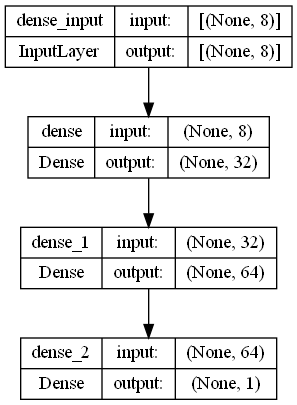

In [10]:
from tensorflow.keras.utils import plot_model

plot_model(spfnet, to_file='spfnet_model.png', show_shapes=True, show_layer_names=True)

In [10]:
hist = spfnet.fit(X_train, y_train, batch_size=32, validation_data=(X_test, y_test),epochs=500, verbose=2)

Epoch 1/500
204/204 - 3s - loss: 0.2677 - root_mean_squared_error: 0.5174 - val_loss: 0.1135 - val_root_mean_squared_error: 0.3368 - 3s/epoch - 15ms/step
Epoch 2/500
204/204 - 1s - loss: 0.0980 - root_mean_squared_error: 0.3130 - val_loss: 0.1054 - val_root_mean_squared_error: 0.3246 - 772ms/epoch - 4ms/step
Epoch 3/500
204/204 - 1s - loss: 0.0980 - root_mean_squared_error: 0.3131 - val_loss: 0.1075 - val_root_mean_squared_error: 0.3279 - 977ms/epoch - 5ms/step
Epoch 4/500
204/204 - 1s - loss: 0.0928 - root_mean_squared_error: 0.3046 - val_loss: 0.1054 - val_root_mean_squared_error: 0.3246 - 1s/epoch - 5ms/step
Epoch 5/500
204/204 - 1s - loss: 0.0923 - root_mean_squared_error: 0.3038 - val_loss: 0.1059 - val_root_mean_squared_error: 0.3255 - 1s/epoch - 5ms/step
Epoch 6/500
204/204 - 1s - loss: 0.0922 - root_mean_squared_error: 0.3036 - val_loss: 0.1071 - val_root_mean_squared_error: 0.3272 - 1s/epoch - 6ms/step
Epoch 7/500
204/204 - 1s - loss: 0.0895 - root_mean_squared_error: 0.2992 -

Epoch 54/500
204/204 - 1s - loss: 0.0701 - root_mean_squared_error: 0.2648 - val_loss: 0.1042 - val_root_mean_squared_error: 0.3228 - 972ms/epoch - 5ms/step
Epoch 55/500
204/204 - 1s - loss: 0.0713 - root_mean_squared_error: 0.2670 - val_loss: 0.0960 - val_root_mean_squared_error: 0.3098 - 1s/epoch - 6ms/step
Epoch 56/500
204/204 - 1s - loss: 0.0705 - root_mean_squared_error: 0.2656 - val_loss: 0.0969 - val_root_mean_squared_error: 0.3114 - 1s/epoch - 6ms/step
Epoch 57/500
204/204 - 1s - loss: 0.0703 - root_mean_squared_error: 0.2652 - val_loss: 0.1011 - val_root_mean_squared_error: 0.3180 - 686ms/epoch - 3ms/step
Epoch 58/500
204/204 - 1s - loss: 0.0693 - root_mean_squared_error: 0.2632 - val_loss: 0.0964 - val_root_mean_squared_error: 0.3105 - 720ms/epoch - 4ms/step
Epoch 59/500
204/204 - 1s - loss: 0.0699 - root_mean_squared_error: 0.2644 - val_loss: 0.0978 - val_root_mean_squared_error: 0.3127 - 859ms/epoch - 4ms/step
Epoch 60/500
204/204 - 1s - loss: 0.0693 - root_mean_squared_err

Epoch 107/500
204/204 - 1s - loss: 0.0587 - root_mean_squared_error: 0.2422 - val_loss: 0.1002 - val_root_mean_squared_error: 0.3165 - 979ms/epoch - 5ms/step
Epoch 108/500
204/204 - 1s - loss: 0.0570 - root_mean_squared_error: 0.2387 - val_loss: 0.1130 - val_root_mean_squared_error: 0.3361 - 810ms/epoch - 4ms/step
Epoch 109/500
204/204 - 1s - loss: 0.0598 - root_mean_squared_error: 0.2446 - val_loss: 0.0974 - val_root_mean_squared_error: 0.3120 - 762ms/epoch - 4ms/step
Epoch 110/500
204/204 - 1s - loss: 0.0576 - root_mean_squared_error: 0.2401 - val_loss: 0.0966 - val_root_mean_squared_error: 0.3109 - 630ms/epoch - 3ms/step
Epoch 111/500
204/204 - 1s - loss: 0.0568 - root_mean_squared_error: 0.2383 - val_loss: 0.0998 - val_root_mean_squared_error: 0.3160 - 886ms/epoch - 4ms/step
Epoch 112/500
204/204 - 1s - loss: 0.0584 - root_mean_squared_error: 0.2417 - val_loss: 0.0950 - val_root_mean_squared_error: 0.3082 - 930ms/epoch - 5ms/step
Epoch 113/500
204/204 - 2s - loss: 0.0548 - root_mea

204/204 - 1s - loss: 0.0476 - root_mean_squared_error: 0.2182 - val_loss: 0.0993 - val_root_mean_squared_error: 0.3151 - 866ms/epoch - 4ms/step
Epoch 160/500
204/204 - 1s - loss: 0.0473 - root_mean_squared_error: 0.2176 - val_loss: 0.1020 - val_root_mean_squared_error: 0.3194 - 858ms/epoch - 4ms/step
Epoch 161/500
204/204 - 1s - loss: 0.0470 - root_mean_squared_error: 0.2168 - val_loss: 0.1042 - val_root_mean_squared_error: 0.3228 - 870ms/epoch - 4ms/step
Epoch 162/500
204/204 - 1s - loss: 0.0460 - root_mean_squared_error: 0.2145 - val_loss: 0.0987 - val_root_mean_squared_error: 0.3141 - 861ms/epoch - 4ms/step
Epoch 163/500
204/204 - 1s - loss: 0.0464 - root_mean_squared_error: 0.2154 - val_loss: 0.1010 - val_root_mean_squared_error: 0.3178 - 803ms/epoch - 4ms/step
Epoch 164/500
204/204 - 1s - loss: 0.0468 - root_mean_squared_error: 0.2163 - val_loss: 0.0996 - val_root_mean_squared_error: 0.3156 - 674ms/epoch - 3ms/step
Epoch 165/500
204/204 - 1s - loss: 0.0452 - root_mean_squared_erro

Epoch 212/500
204/204 - 1s - loss: 0.0396 - root_mean_squared_error: 0.1990 - val_loss: 0.1003 - val_root_mean_squared_error: 0.3168 - 1s/epoch - 6ms/step
Epoch 213/500
204/204 - 1s - loss: 0.0385 - root_mean_squared_error: 0.1961 - val_loss: 0.1014 - val_root_mean_squared_error: 0.3184 - 997ms/epoch - 5ms/step
Epoch 214/500
204/204 - 1s - loss: 0.0380 - root_mean_squared_error: 0.1951 - val_loss: 0.1004 - val_root_mean_squared_error: 0.3168 - 1s/epoch - 6ms/step
Epoch 215/500
204/204 - 1s - loss: 0.0377 - root_mean_squared_error: 0.1941 - val_loss: 0.1063 - val_root_mean_squared_error: 0.3261 - 1s/epoch - 6ms/step
Epoch 216/500
204/204 - 1s - loss: 0.0374 - root_mean_squared_error: 0.1933 - val_loss: 0.1062 - val_root_mean_squared_error: 0.3258 - 1s/epoch - 5ms/step
Epoch 217/500
204/204 - 1s - loss: 0.0385 - root_mean_squared_error: 0.1962 - val_loss: 0.1038 - val_root_mean_squared_error: 0.3221 - 1s/epoch - 6ms/step
Epoch 218/500
204/204 - 1s - loss: 0.0382 - root_mean_squared_error

Epoch 265/500
204/204 - 1s - loss: 0.0333 - root_mean_squared_error: 0.1825 - val_loss: 0.1036 - val_root_mean_squared_error: 0.3218 - 870ms/epoch - 4ms/step
Epoch 266/500
204/204 - 1s - loss: 0.0327 - root_mean_squared_error: 0.1807 - val_loss: 0.1046 - val_root_mean_squared_error: 0.3234 - 1s/epoch - 6ms/step
Epoch 267/500
204/204 - 1s - loss: 0.0329 - root_mean_squared_error: 0.1815 - val_loss: 0.1028 - val_root_mean_squared_error: 0.3206 - 655ms/epoch - 3ms/step
Epoch 268/500
204/204 - 1s - loss: 0.0324 - root_mean_squared_error: 0.1801 - val_loss: 0.1095 - val_root_mean_squared_error: 0.3308 - 1s/epoch - 5ms/step
Epoch 269/500
204/204 - 1s - loss: 0.0327 - root_mean_squared_error: 0.1808 - val_loss: 0.0998 - val_root_mean_squared_error: 0.3159 - 564ms/epoch - 3ms/step
Epoch 270/500
204/204 - 1s - loss: 0.0326 - root_mean_squared_error: 0.1805 - val_loss: 0.1083 - val_root_mean_squared_error: 0.3291 - 529ms/epoch - 3ms/step
Epoch 271/500
204/204 - 1s - loss: 0.0315 - root_mean_squa

Epoch 318/500
204/204 - 1s - loss: 0.0283 - root_mean_squared_error: 0.1682 - val_loss: 0.1129 - val_root_mean_squared_error: 0.3361 - 1s/epoch - 5ms/step
Epoch 319/500
204/204 - 1s - loss: 0.0296 - root_mean_squared_error: 0.1719 - val_loss: 0.1081 - val_root_mean_squared_error: 0.3288 - 928ms/epoch - 5ms/step
Epoch 320/500
204/204 - 1s - loss: 0.0276 - root_mean_squared_error: 0.1662 - val_loss: 0.1081 - val_root_mean_squared_error: 0.3288 - 647ms/epoch - 3ms/step
Epoch 321/500
204/204 - 1s - loss: 0.0295 - root_mean_squared_error: 0.1717 - val_loss: 0.1086 - val_root_mean_squared_error: 0.3295 - 744ms/epoch - 4ms/step
Epoch 322/500
204/204 - 1s - loss: 0.0279 - root_mean_squared_error: 0.1671 - val_loss: 0.1090 - val_root_mean_squared_error: 0.3302 - 777ms/epoch - 4ms/step
Epoch 323/500
204/204 - 1s - loss: 0.0272 - root_mean_squared_error: 0.1648 - val_loss: 0.1095 - val_root_mean_squared_error: 0.3310 - 1s/epoch - 6ms/step
Epoch 324/500
204/204 - 1s - loss: 0.0266 - root_mean_squa

Epoch 371/500
204/204 - 1s - loss: 0.0239 - root_mean_squared_error: 0.1546 - val_loss: 0.1114 - val_root_mean_squared_error: 0.3338 - 945ms/epoch - 5ms/step
Epoch 372/500
204/204 - 1s - loss: 0.0252 - root_mean_squared_error: 0.1588 - val_loss: 0.1157 - val_root_mean_squared_error: 0.3402 - 832ms/epoch - 4ms/step
Epoch 373/500
204/204 - 1s - loss: 0.0236 - root_mean_squared_error: 0.1538 - val_loss: 0.1113 - val_root_mean_squared_error: 0.3336 - 968ms/epoch - 5ms/step
Epoch 374/500
204/204 - 1s - loss: 0.0243 - root_mean_squared_error: 0.1558 - val_loss: 0.1149 - val_root_mean_squared_error: 0.3389 - 1s/epoch - 5ms/step
Epoch 375/500
204/204 - 1s - loss: 0.0238 - root_mean_squared_error: 0.1544 - val_loss: 0.1194 - val_root_mean_squared_error: 0.3456 - 980ms/epoch - 5ms/step
Epoch 376/500
204/204 - 1s - loss: 0.0238 - root_mean_squared_error: 0.1542 - val_loss: 0.1195 - val_root_mean_squared_error: 0.3456 - 782ms/epoch - 4ms/step
Epoch 377/500
204/204 - 1s - loss: 0.0246 - root_mean_s

Epoch 424/500
204/204 - 1s - loss: 0.0233 - root_mean_squared_error: 0.1527 - val_loss: 0.1182 - val_root_mean_squared_error: 0.3438 - 711ms/epoch - 3ms/step
Epoch 425/500
204/204 - 1s - loss: 0.0227 - root_mean_squared_error: 0.1506 - val_loss: 0.1133 - val_root_mean_squared_error: 0.3366 - 779ms/epoch - 4ms/step
Epoch 426/500
204/204 - 1s - loss: 0.0217 - root_mean_squared_error: 0.1472 - val_loss: 0.1147 - val_root_mean_squared_error: 0.3387 - 856ms/epoch - 4ms/step
Epoch 427/500
204/204 - 1s - loss: 0.0216 - root_mean_squared_error: 0.1470 - val_loss: 0.1178 - val_root_mean_squared_error: 0.3433 - 953ms/epoch - 5ms/step
Epoch 428/500
204/204 - 1s - loss: 0.0216 - root_mean_squared_error: 0.1468 - val_loss: 0.1173 - val_root_mean_squared_error: 0.3425 - 754ms/epoch - 4ms/step
Epoch 429/500
204/204 - 1s - loss: 0.0227 - root_mean_squared_error: 0.1508 - val_loss: 0.1184 - val_root_mean_squared_error: 0.3441 - 1s/epoch - 6ms/step
Epoch 430/500
204/204 - 1s - loss: 0.0219 - root_mean_s

204/204 - 1s - loss: 0.0185 - root_mean_squared_error: 0.1360 - val_loss: 0.1182 - val_root_mean_squared_error: 0.3438 - 675ms/epoch - 3ms/step
Epoch 477/500
204/204 - 1s - loss: 0.0198 - root_mean_squared_error: 0.1405 - val_loss: 0.1144 - val_root_mean_squared_error: 0.3382 - 724ms/epoch - 4ms/step
Epoch 478/500
204/204 - 1s - loss: 0.0212 - root_mean_squared_error: 0.1455 - val_loss: 0.1161 - val_root_mean_squared_error: 0.3408 - 656ms/epoch - 3ms/step
Epoch 479/500
204/204 - 1s - loss: 0.0210 - root_mean_squared_error: 0.1448 - val_loss: 0.1226 - val_root_mean_squared_error: 0.3502 - 682ms/epoch - 3ms/step
Epoch 480/500
204/204 - 1s - loss: 0.0245 - root_mean_squared_error: 0.1564 - val_loss: 0.1173 - val_root_mean_squared_error: 0.3425 - 740ms/epoch - 4ms/step
Epoch 481/500
204/204 - 1s - loss: 0.0195 - root_mean_squared_error: 0.1395 - val_loss: 0.1163 - val_root_mean_squared_error: 0.3410 - 756ms/epoch - 4ms/step
Epoch 482/500
204/204 - 1s - loss: 0.0195 - root_mean_squared_erro

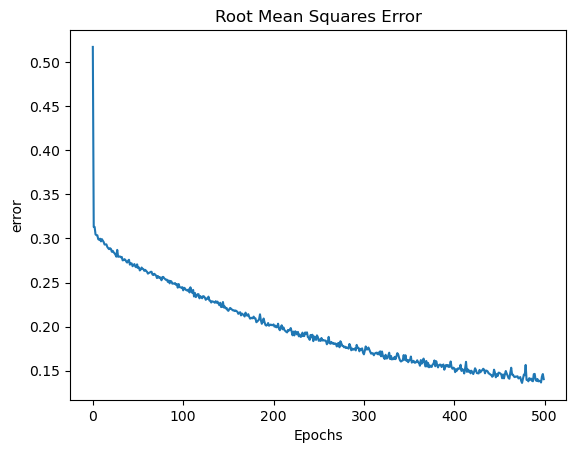

204/204 [==============================] - 1s 4ms/step - loss: 0.0168 - root_mean_squared_error: 0.1297


[0.01682877354323864, 0.12972576916217804]

In [11]:
plt.plot(hist.history['root_mean_squared_error'])
plt.title('Root Mean Squares Error')
plt.xlabel('Epochs')
plt.ylabel('error')
plt.show()

spfnet.evaluate(X_train, y_train)

In [12]:
from sklearn.metrics import mean_squared_error

y_pred = spfnet.predict(X_test) # get model predictions (scaled inputs here)
y_pred_orig = sc_y.inverse_transform(y_pred) # unscale the predictions
y_test_orig = sc_y.inverse_transform(y_test) # unscale the true test outcomes

RMSE_orig = mean_squared_error(y_pred_orig, y_test_orig, squared=False)
RMSE_orig

68/68 [==============================] - 1s 4ms/step


15.925643813240491

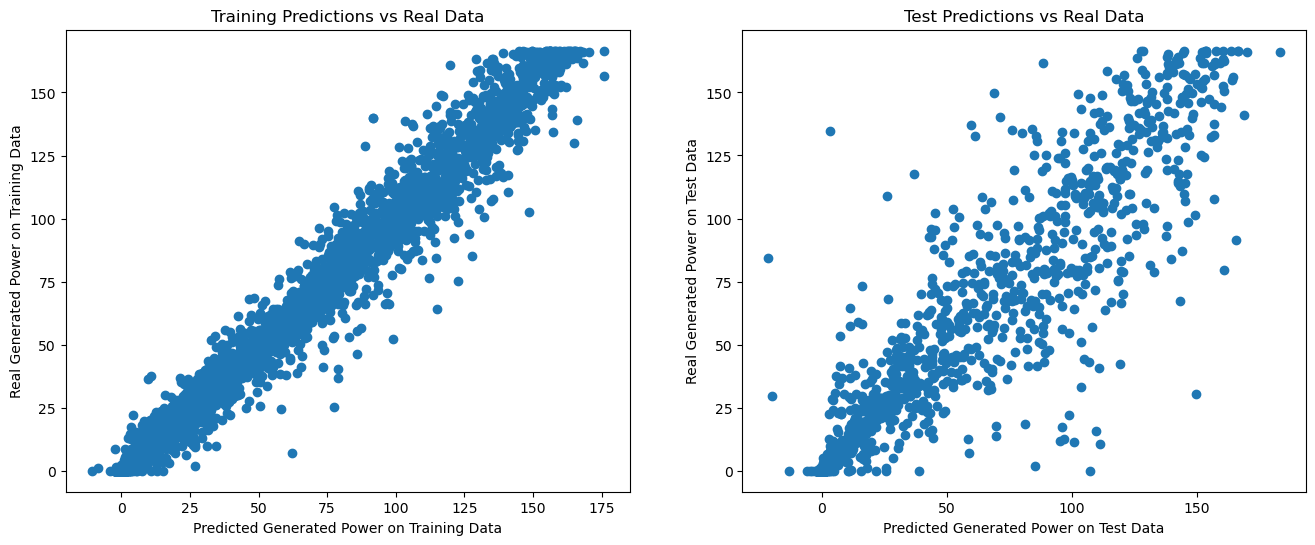

In [18]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,2)
plt.scatter(y_pred_orig, y_test_orig)
plt.xlabel('Predicted Generated Power on Test Data')
plt.ylabel('Real Generated Power on Test Data')
plt.title('Test Predictions vs Real Data')
#plt.scatter(y_test_orig, sc_X.inverse_transform(X_test)[:,2], color='green')
plt.subplot(1,2,1)
plt.scatter(train_pred_orig, y_train_orig)
plt.xlabel('Predicted Generated Power on Training Data')
plt.ylabel('Real Generated Power on Training Data')
plt.title('Training Predictions vs Real Data')
plt.show()

In [19]:
results = np.concatenate((y_test_orig, y_pred_orig), 1)
results = pd.DataFrame(data=results)
results.columns = ['Real Solar Power Produced', 'Predicted Solar Power']
#results = results.sort_values(by=['Real Solar Power Produced'])
pd.options.display.float_format = "{:,.2f}".format
results[800:820]
results[8:18]

,Real Solar Power Produced,Predicted Solar Power
8,140.02,148.23
9,0.00,0.15
10,5.00,2.82
11,152.00,138.31
12,0.00,0.60
13,0.76,0.31
14,0.00,-0.42
15,34.87,39.27
16,0.57,0.02
17,0.00,-0.35


In [23]:
df_results = pd.DataFrame.from_dict({
    'R2 Score of Whole Data Frame': r2_score(pred_whole_orig, y),
    'R2 Score of Training Set': r2_score(train_pred_orig, y_train_orig),
    'R2 Score of Test Set': r2_score(y_pred_orig, y_test_orig),
    'Mean of Test Set': np.mean(y_pred_orig),
    'Standard Deviation pf Test Set': np.std(y_pred_orig),
    'Relative Standard Deviation': np.std(y_pred_orig) / np.mean(y_pred_orig),
},orient='index', columns=['Value'])
display(df_results.style.background_gradient(cmap='afmhot', axis=0))

,Value
R2 Score of Whole Data Frame,0.955764
R2 Score of Training Set,0.982546
R2 Score of Test Set,0.882790
Mean of Test Set,31.155756
Standard Deviation pf Test Set,46.517235
Relative Standard Deviation,1.493054


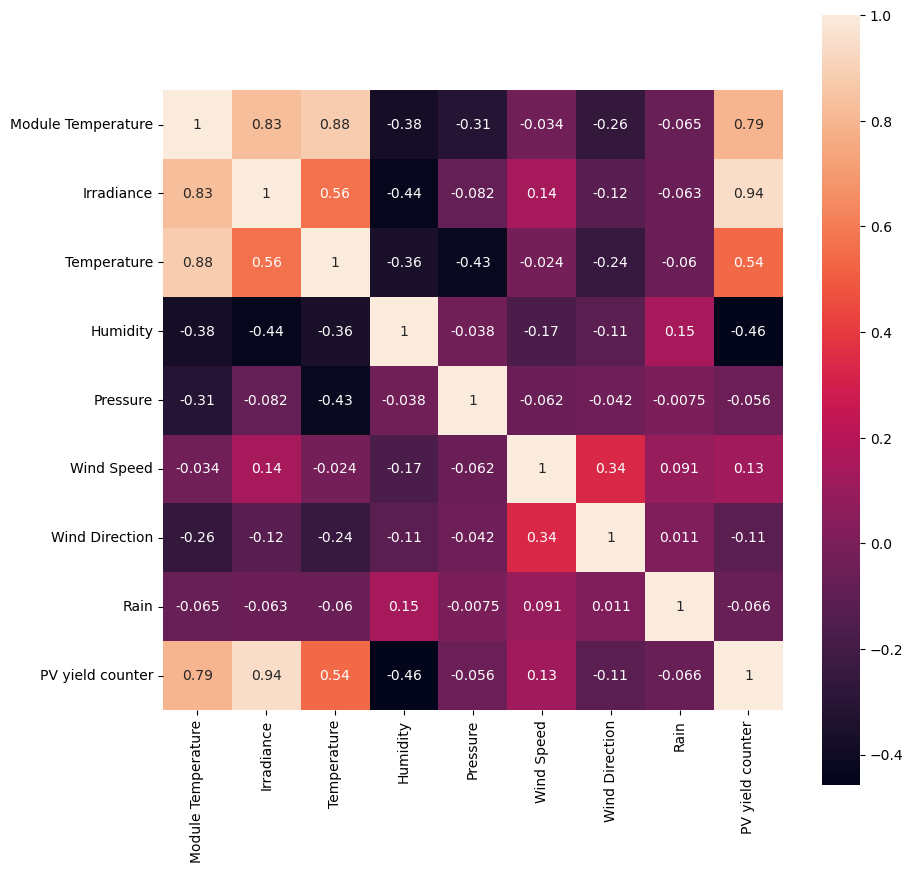

In [24]:
corr = dataset.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, square=True);

In [25]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha = 0.001)

lasso.fit(X_train, y_train)

y_pred_lasso = lasso.predict(X_test)

lasso_coeff = pd.DataFrame({'Feature Importance':lasso.coef_}, index=dataset.columns[:-1])
lasso_coeff.sort_values('Feature Importance', ascending=False)

,Feature Importance
Irradiance,0.85
Module Temperature,0.14
Pressure,0.03
Wind Direction,0.00
Rain,0.00
Wind Speed,-0.00
Humidity,-0.05
Temperature,-0.06


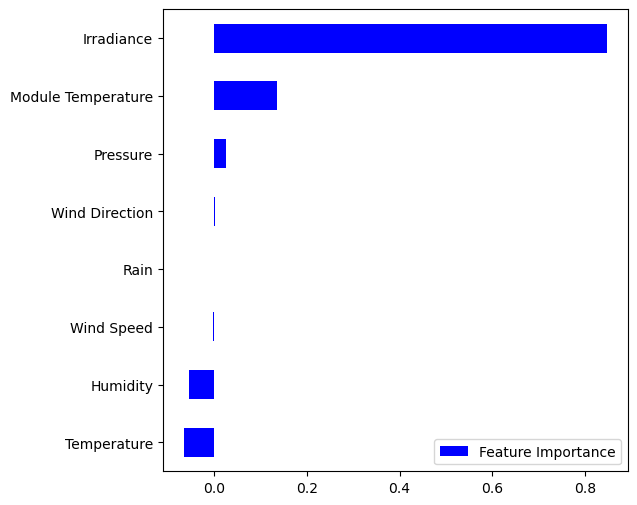

In [26]:
g = lasso_coeff[lasso_coeff['Feature Importance']!=0].sort_values('Feature Importance').plot(kind='barh',figsize=(6,6), cmap='winter')

TEST METRICS

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_orig, y_pred_orig)
mae = mean_absolute_error(y_test_orig, y_pred_orig)
r2 = r2_score(y_test_orig, y_pred_orig)
rmse = np.sqrt(mse)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R²) Score:", r2)
print("Root Mean Squared Error (RMSE):", rmse)


Mean Squared Error (MSE): 253.6261308662051
Mean Absolute Error (MAE): 7.5277532405577805
R-squared (R²) Score: 0.8843964957271105
Root Mean Squared Error (RMSE): 15.925643813240491


TRAINING METRICS

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate predictions on the training data
train_pred = spfnet.predict(X_train)  # Assuming X_train contains your scaled training features

# Inverse transform the scaled predictions to get original values
train_pred_orig = sc_y.inverse_transform(train_pred)

# Inverse transform the scaled training labels to get original values
y_train_orig = sc_y.inverse_transform(y_train)


mse_train = mean_squared_error(y_train_orig, train_pred_orig)
mae_train = mean_absolute_error(y_train_orig, train_pred_orig)
r2_train = r2_score(y_train_orig, train_pred_orig)
rmse_train = np.sqrt(mse_train)

print("Training Data Metrics:")
print("Mean Squared Error (MSE):", mse_train)
print("Mean Absolute Error (MAE):", mae_train)
print("R-squared (R²) Score:", r2_train)
print("Root Mean Squared Error (RMSE):", rmse_train)


204/204 [==============================] - 1s 2ms/step
Training Data Metrics:
Mean Squared Error (MSE): 36.51528488131084
Mean Absolute Error (MAE): 3.080251624324834
R-squared (R²) Score: 0.9831712208193562
Root Mean Squared Error (RMSE): 6.042787840170367


# October 2022

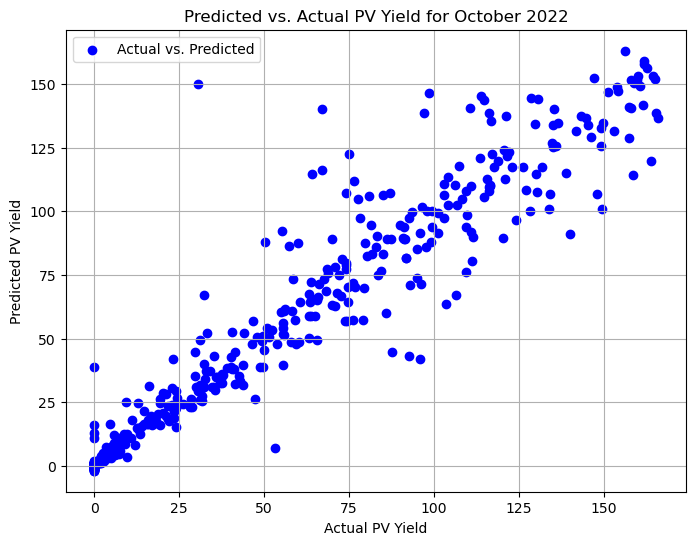

In [60]:
# Filter dataset for October 2022
october_data = dataset2[(dataset2['Timestamp'] >= '2022-10-01') & (dataset2['Timestamp'] <= '2022-10-31')]

# Get the corresponding indices for October 2022 data
october_indices = october_data.index
actual_october_yield = october_data['PV yield counter'].values
predicted_october_yield = pred_whole_orig[october_indices]

plt.figure(figsize=(8, 6))
plt.scatter(actual_october_yield, predicted_october_yield, color='b', label='Actual vs. Predicted')
plt.xlabel('Actual PV Yield')
plt.ylabel('Predicted PV Yield')
plt.title('Predicted vs. Actual PV Yield for October 2022')
plt.legend()
plt.grid(True)
plt.show()


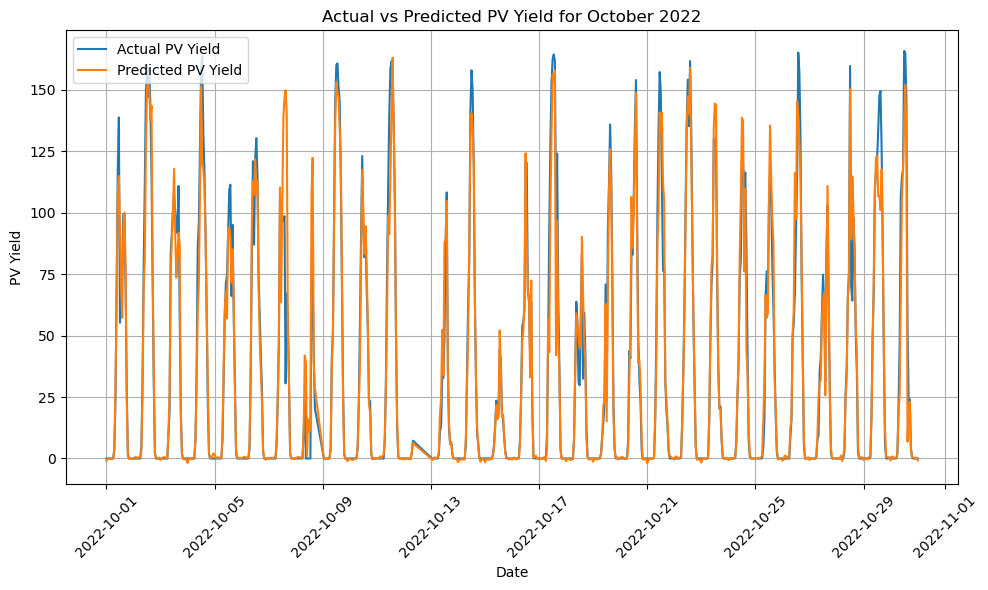

Metrics for October 2022:
Mean Squared Error (MSE): 144.4539504542783
Mean Absolute Error (MAE): 5.4583731397818624
R-squared (R²) Score: 0.9380910148001582
Root Mean Squared Error (RMSE): 12.01889971895424
Mean Absolute Percentage Error (MAPE) for October 2022: 1.5966523567723399


In [71]:
# Filter dataset for October 2022
october_data = dataset2[(dataset2['Timestamp'] >= '2022-10-01') & (dataset2['Timestamp'] <= '2022-10-31')]

# Get the corresponding indices for October 2022 data
october_indices = october_data.index
actual_october_yield = october_data['PV yield counter'].values
predicted_october_yield = pred_whole_orig[october_indices]

plt.figure(figsize=(10, 6))
plt.plot(october_data['Timestamp'], actual_october_yield, label='Actual PV Yield', )
plt.plot(october_data['Timestamp'], predicted_october_yield, label='Predicted PV Yield', )
plt.xlabel('Date')
plt.ylabel('PV Yield')
plt.title('Actual vs Predicted PV Yield for October 2022')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mse_october = mean_squared_error(actual_october_yield, predicted_october_yield)
mae_october = mean_absolute_error(actual_october_yield, predicted_october_yield)
r2_october = r2_score(actual_october_yield, predicted_october_yield)
rmse_october = np.sqrt(mse_october)

print("Metrics for October 2022:")
print("Mean Squared Error (MSE):", mse_october)
print("Mean Absolute Error (MAE):", mae_october)
print("R-squared (R²) Score:", r2_october)
print("Root Mean Squared Error (RMSE):", rmse_october)

average_actual_october_yield = np.mean(actual_october_yield)
average_predicted_october_yield = np.mean(predicted_october_yield)
mape_october = np.abs((average_actual_october_yield - average_predicted_october_yield) / average_actual_october_yield) * 100

print("Mean Absolute Percentage Error (MAPE) for October 2022:", mape_october)


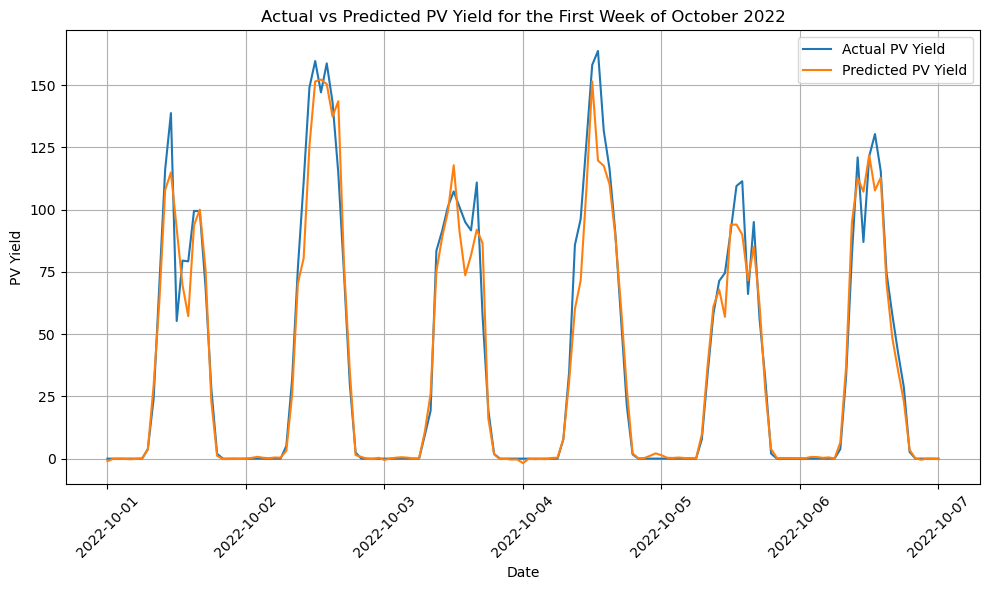

Metrics for the First Week of October 2022:
Mean Squared Error (MSE): 99.87475304150401
Mean Absolute Error (MAE): 5.448867668724229
R-squared (R²) Score: 0.9608562970199196
Root Mean Squared Error (RMSE): 9.993735689996209
Mean Absolute Percentage Error (MAPE) for the First Week of October 2022: 5.240822386819033


In [72]:
# Filter dataset for the first week of October 2022
first_week_october_data = dataset2[(dataset2['Timestamp'] >= '2022-10-01') & (dataset2['Timestamp'] <= '2022-10-07')]

# Get the corresponding indices for the first week of October 2022 data
first_week_october_indices = first_week_october_data.index

# Extract actual PV yield values for the first week of October 2022
actual_first_week_yield = first_week_october_data['PV yield counter'].values
predicted_first_week_yield = pred_whole_orig[first_week_october_indices]
plt.figure(figsize=(10, 6))
plt.plot(first_week_october_data['Timestamp'], actual_first_week_yield, label='Actual PV Yield', )
plt.plot(first_week_october_data['Timestamp'], predicted_first_week_yield, label='Predicted PV Yield', )
plt.xlabel('Date')
plt.ylabel('PV Yield')
plt.title('Actual vs Predicted PV Yield for the First Week of October 2022')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mse_first_week_october = mean_squared_error(actual_first_week_yield, predicted_first_week_yield)
mae_first_week_october = mean_absolute_error(actual_first_week_yield, predicted_first_week_yield)
r2_first_week_october = r2_score(actual_first_week_yield, predicted_first_week_yield)
rmse_first_week_october = np.sqrt(mse_first_week_october)

print("Metrics for the First Week of October 2022:")
print("Mean Squared Error (MSE):", mse_first_week_october)
print("Mean Absolute Error (MAE):", mae_first_week_october)
print("R-squared (R²) Score:", r2_first_week_october)
print("Root Mean Squared Error (RMSE):", rmse_first_week_october)

average_actual_first_week_yield = np.mean(actual_first_week_yield)
average_predicted_first_week_yield = np.mean(predicted_first_week_yield)
mape_first_week_october = np.abs((average_actual_first_week_yield - average_predicted_first_week_yield) / average_actual_first_week_yield) * 100

print("Mean Absolute Percentage Error (MAPE) for the First Week of October 2022:", mape_first_week_october)



1/1 [==============================] - 0s 41ms/step


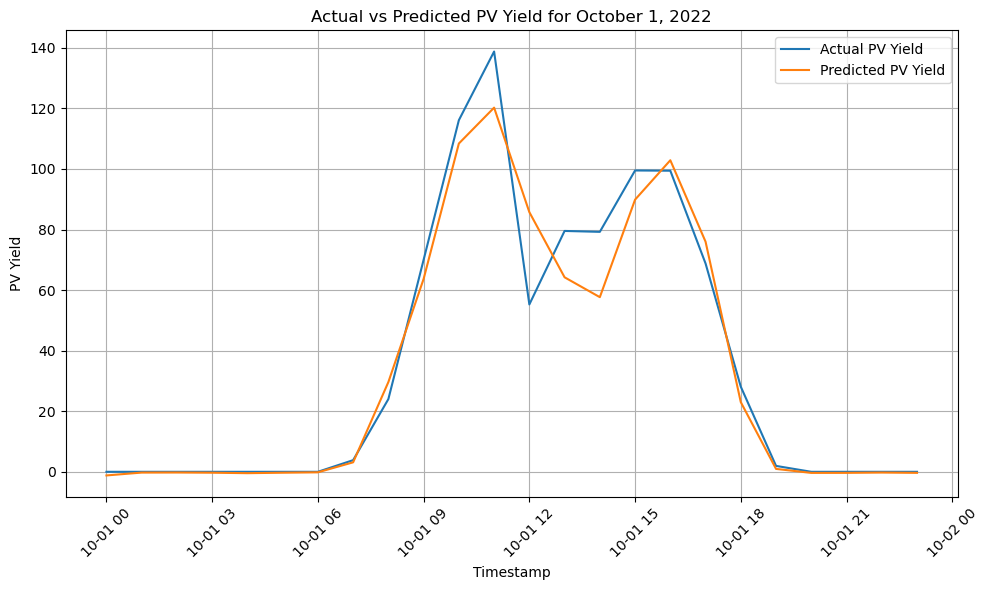

Metrics for October 1, 2022:
Mean Squared Error (MSE): 95.37758258775575
Mean Absolute Error (MAE): 5.700930113772551
R-squared (R²) Score: 0.9523610447896309
Root Mean Squared Error (RMSE): 9.766144714663804
Mean Absolute Percentage Error (MAPE) for October 1, 2022: 5.010609372650303


In [73]:
# Filter dataset for October 1, 2022
first_day_october_data = dataset2[dataset2['Timestamp'].dt.date == pd.Timestamp('2022-10-01').date()]

# Extract features (excluding 'Timestamp') and target variable for the first day of October
X_first_day = first_day_october_data.drop(columns=['Timestamp', 'PV yield counter']).values
y_first_day = first_day_october_data['PV yield counter'].values

# Scale features for prediction
X_first_day_scaled = sc_X.transform(X_first_day)
predicted_first_day_yield = spfnet.predict(X_first_day_scaled)
predicted_first_day_yield_orig = sc_y.inverse_transform(predicted_first_day_yield)



plt.figure(figsize=(10, 6))
plt.plot(first_day_october_data['Timestamp'], y_first_day, label='Actual PV Yield')
plt.plot(first_day_october_data['Timestamp'], predicted_first_day_yield_orig, label='Predicted PV Yield')
plt.xlabel('Timestamp')
plt.ylabel('PV Yield')
plt.title('Actual vs Predicted PV Yield for October 1, 2022')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


mse_first_day = mean_squared_error(y_first_day, predicted_first_day_yield_orig)
mae_first_day = mean_absolute_error(y_first_day, predicted_first_day_yield_orig)
r2_first_day = r2_score(y_first_day, predicted_first_day_yield_orig)
rmse_first_day = np.sqrt(mse_first_day)

print("Metrics for October 1, 2022:")
print("Mean Squared Error (MSE):", mse_first_day)
print("Mean Absolute Error (MAE):", mae_first_day)
print("R-squared (R²) Score:", r2_first_day)
print("Root Mean Squared Error (RMSE):", rmse_first_day)

average_actual_first_day_yield = np.mean(y_first_day)
average_predicted_first_day_yield = np.mean(predicted_first_day_yield_orig)
mape_first_day_october = np.abs((average_actual_first_day_yield - average_predicted_first_day_yield) / average_actual_first_day_yield) * 100

print("Mean Absolute Percentage Error (MAPE) for October 1, 2022:", mape_first_day_october)



1/1 [==============================] - 0s 36ms/step


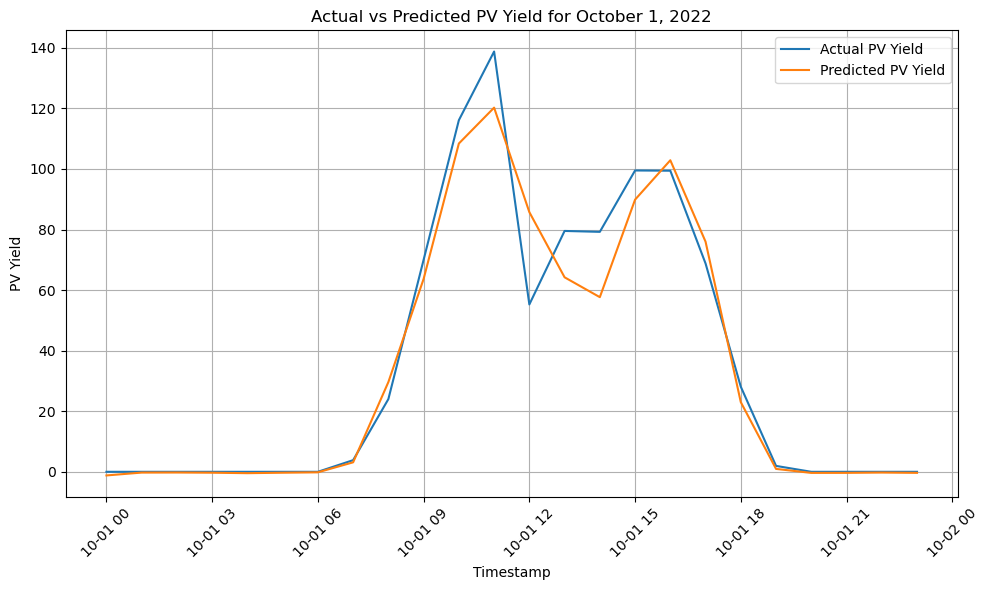

Metrics for October 1, 2022:
Mean Absolute Error (MAE): 5.700930113772551
Mean Squared Error (MSE): 95.37758258775575
Root Mean Squared Error (RMSE): 9.766144714663804
R-squared (R²) Score: 0.9523610447896309
Mean Absolute Percentage Error (MAPE): 5.010609372650303


In [65]:
# Filter dataset for October 1, 2022
first_day_october_data = dataset2[dataset2['Timestamp'].dt.date == pd.Timestamp('2022-10-01').date()]

# Extract features (excluding 'Timestamp') and target variable for the first day of October
X_first_day = first_day_october_data.drop(columns=['Timestamp', 'PV yield counter']).values
y_first_day = first_day_october_data['PV yield counter'].values


X_first_day_scaled = sc_X.transform(X_first_day)
predicted_first_day_yield = spfnet.predict(X_first_day_scaled)
predicted_first_day_yield_orig = sc_y.inverse_transform(predicted_first_day_yield)

plt.figure(figsize=(10, 6))
plt.plot(first_day_october_data['Timestamp'], y_first_day, label='Actual PV Yield')
plt.plot(first_day_october_data['Timestamp'], predicted_first_day_yield_orig, label='Predicted PV Yield')
plt.xlabel('Timestamp')
plt.ylabel('PV Yield')
plt.title('Actual vs Predicted PV Yield for October 1, 2022')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mse_first_day = mean_squared_error(y_first_day, predicted_first_day_yield_orig)
mae_first_day = mean_absolute_error(y_first_day, predicted_first_day_yield_orig)
r2_first_day = r2_score(y_first_day, predicted_first_day_yield_orig)
rmse_first_day = np.sqrt(mse_first_day)

average_y_first_day_actual = np.mean(y_first_day)
average_y_first_day_pred = np.mean(predicted_first_day_yield_orig)
mape_first_day = np.abs((average_y_first_day_actual - average_y_first_day_pred) / average_y_first_day_actual) * 100

print("Metrics for October 1, 2022:")
print("Mean Absolute Error (MAE):", mae_first_day)
print("Mean Squared Error (MSE):", mse_first_day)
print("Root Mean Squared Error (RMSE):", rmse_first_day)
print("R-squared (R²) Score:", r2_first_day)
print("Mean Absolute Percentage Error (MAPE):", mape_first_day)


DECEMBER 2022

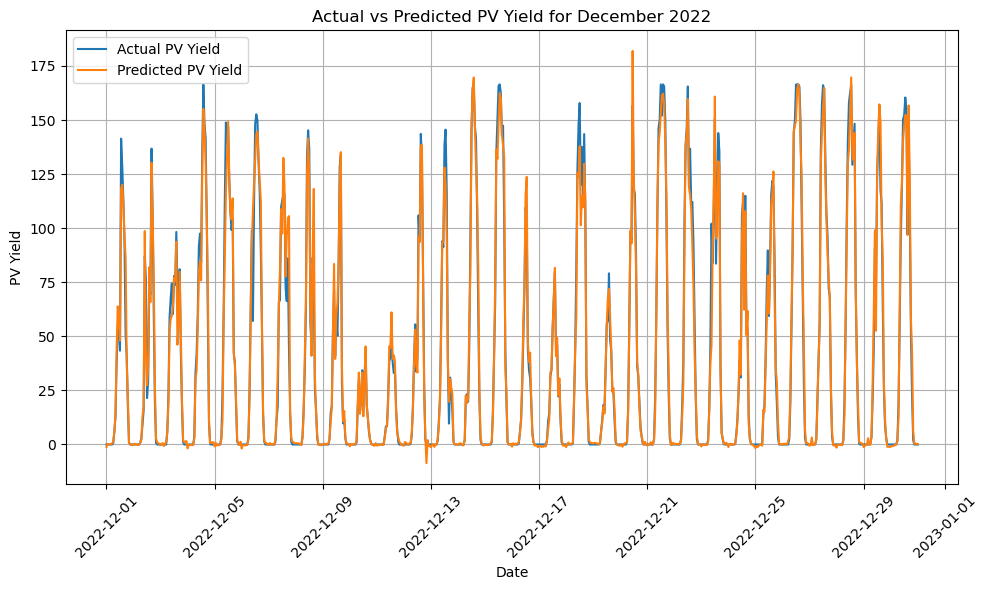

Metrics for December 2022:
Mean Squared Error (MSE): 61.64425526572836
Mean Absolute Error (MAE): 3.9540951640341904
R-squared (R²) Score: 0.9769550687794509
Root Mean Squared Error (RMSE): 7.851385563435817
Mean Absolute Percentage Error (MAPE) for December 2022: 0.4857512570624615


In [74]:
# Filter dataset for December 2022
december_data = dataset2[(dataset2['Timestamp'] >= '2022-12-01') & (dataset2['Timestamp'] <= '2022-12-31')]
december_indices = december_data.index
actual_december_yield = december_data['PV yield counter'].values
predicted_december_yield = pred_whole_orig[december_indices]

plt.figure(figsize=(10, 6))
plt.plot(december_data['Timestamp'], actual_december_yield, label='Actual PV Yield', )
plt.plot(december_data['Timestamp'], predicted_december_yield, label='Predicted PV Yield', )
plt.xlabel('Date')
plt.ylabel('PV Yield')
plt.title('Actual vs Predicted PV Yield for December 2022')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mse_december = mean_squared_error(actual_december_yield, predicted_december_yield)
mae_december = mean_absolute_error(actual_december_yield, predicted_december_yield)
r2_december = r2_score(actual_december_yield, predicted_december_yield)
rmse_december = np.sqrt(mse_december)

print("Metrics for December 2022:")
print("Mean Squared Error (MSE):", mse_december)
print("Mean Absolute Error (MAE):", mae_december)
print("R-squared (R²) Score:", r2_december)
print("Root Mean Squared Error (RMSE):", rmse_december)

average_actual_december_yield = np.mean(actual_december_yield)
average_predicted_december_yield = np.mean(predicted_december_yield)
mape_december = np.abs((average_actual_december_yield - average_predicted_december_yield) / average_actual_december_yield) * 100

print("Mean Absolute Percentage Error (MAPE) for December 2022:", mape_december)



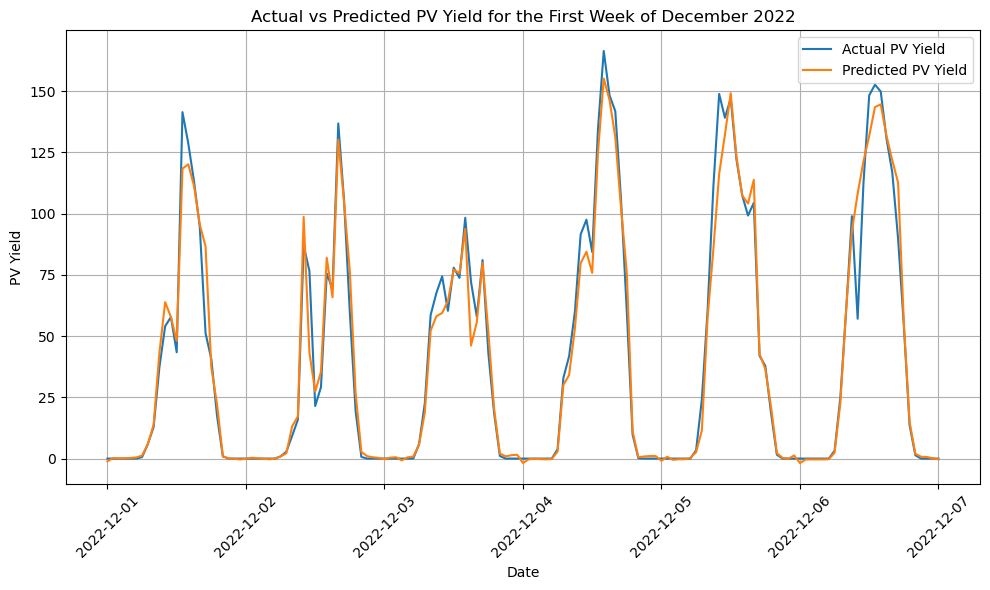

Metrics for the First Week of December 2022:
Mean Squared Error (MSE): 81.75819374947578
Mean Absolute Error (MAE): 4.582662886568287
R-squared (R²) Score: 0.9664830637025335
Root Mean Squared Error (RMSE): 9.042023764040646
Mean Absolute Percentage Error (MAPE) for the First Week of December 2022: 1.43632544258109


In [75]:
# Filter dataset for the first week of December 2022
first_week_december_data = dataset2[(dataset2['Timestamp'] >= '2022-12-01') & (dataset2['Timestamp'] <= '2022-12-07')]
first_week_december_indices = first_week_december_data.index

actual_first_week_december_yield = first_week_december_data['PV yield counter'].values

predicted_first_week_december_yield = pred_whole_orig[first_week_december_indices]

plt.figure(figsize=(10, 6))
plt.plot(first_week_december_data['Timestamp'], actual_first_week_december_yield, label='Actual PV Yield', )
plt.plot(first_week_december_data['Timestamp'], predicted_first_week_december_yield, label='Predicted PV Yield', )
plt.xlabel('Date')
plt.ylabel('PV Yield')
plt.title('Actual vs Predicted PV Yield for the First Week of December 2022')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mse_first_week_december = mean_squared_error(actual_first_week_december_yield, predicted_first_week_december_yield)

mae_first_week_december = mean_absolute_error(actual_first_week_december_yield, predicted_first_week_december_yield)

r2_first_week_december = r2_score(actual_first_week_december_yield, predicted_first_week_december_yield)

rmse_first_week_december = np.sqrt(mse_first_week_december)

print("Metrics for the First Week of December 2022:")
print("Mean Squared Error (MSE):", mse_first_week_december)
print("Mean Absolute Error (MAE):", mae_first_week_december)
print("R-squared (R²) Score:", r2_first_week_december)
print("Root Mean Squared Error (RMSE):", rmse_first_week_december)

average_actual_first_week_december_yield = np.mean(actual_first_week_december_yield)
average_predicted_first_week_december_yield = np.mean(predicted_first_week_december_yield)
mape_first_week_december = np.abs((average_actual_first_week_december_yield - average_predicted_first_week_december_yield) / average_actual_first_week_december_yield) * 100

print("Mean Absolute Percentage Error (MAPE) for the First Week of December 2022:", mape_first_week_december)



1/1 [==============================] - 0s 46ms/step


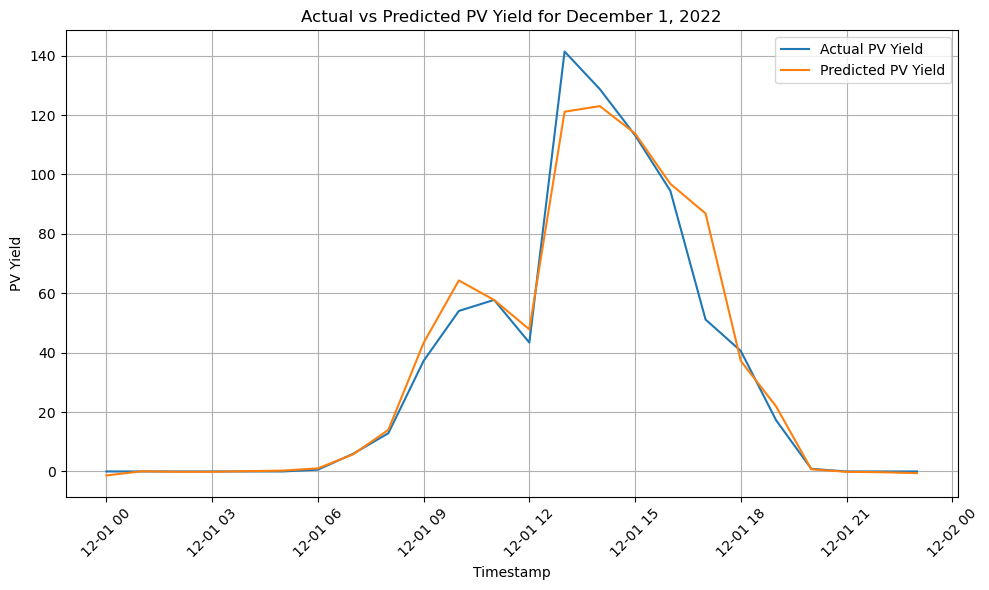

Metrics for December 1, 2022:
Mean Absolute Error (MAE): 4.093252326204132
Mean Squared Error (MSE): 80.11850744998377
Root Mean Squared Error (RMSE): 8.950894226276153
R-squared (R²) Score: 0.9581746215880256
Mean Absolute Percentage Error (MAPE): 4.2389584341698034


In [66]:
# Filter dataset for December 1, 2022
first_day_december_data = dataset2[dataset2['Timestamp'].dt.date == pd.Timestamp('2022-12-01').date()]

# Extract features (excluding 'Timestamp') and target variable for the first day of December
X_first_day_december = first_day_december_data.drop(columns=['Timestamp', 'PV yield counter']).values
y_first_day_december = first_day_december_data['PV yield counter'].values

# Scale features for prediction
X_first_day_december_scaled = sc_X.transform(X_first_day_december)

# Predict PV yield for the first day of December 2022
predicted_first_day_december_yield = spfnet.predict(X_first_day_december_scaled)
predicted_first_day_december_yield_orig = sc_y.inverse_transform(predicted_first_day_december_yield)

plt.figure(figsize=(10, 6))
plt.plot(first_day_december_data['Timestamp'], y_first_day_december, label='Actual PV Yield')
plt.plot(first_day_december_data['Timestamp'], predicted_first_day_december_yield_orig, label='Predicted PV Yield')
plt.xlabel('Timestamp')
plt.ylabel('PV Yield')
plt.title('Actual vs Predicted PV Yield for December 1, 2022')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mse_first_day_december = mean_squared_error(y_first_day_december, predicted_first_day_december_yield_orig)

mae_first_day_december = mean_absolute_error(y_first_day_december, predicted_first_day_december_yield_orig)

r2_first_day_december = r2_score(y_first_day_december, predicted_first_day_december_yield_orig)

rmse_first_day_december = np.sqrt(mse_first_day_december)

average_y_first_day_december_actual = np.mean(y_first_day_december)
average_y_first_day_december_pred = np.mean(predicted_first_day_december_yield_orig)
mape_first_day_december = np.abs((average_y_first_day_december_actual - average_y_first_day_december_pred) / average_y_first_day_december_actual) * 100

print("Metrics for December 1, 2022:")
print("Mean Absolute Error (MAE):", mae_first_day_december)
print("Mean Squared Error (MSE):", mse_first_day_december)
print("Root Mean Squared Error (RMSE):", rmse_first_day_december)
print("R-squared (R²) Score:", r2_first_day_december)
print("Mean Absolute Percentage Error (MAPE):", mape_first_day_december)


MARCH 2023

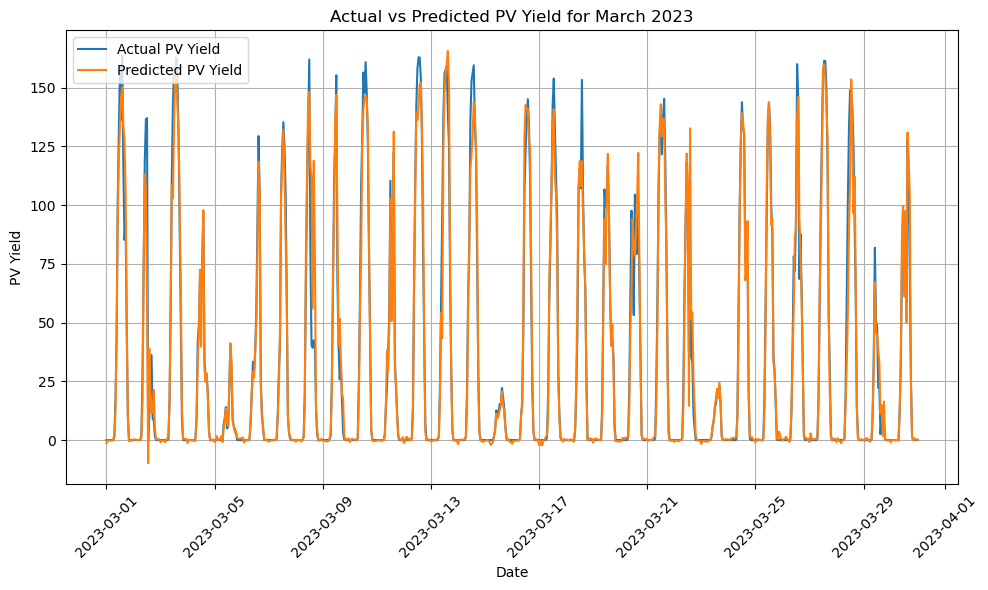

Metrics for March 2023:
Mean Squared Error (MSE): 100.5407870297251
Mean Absolute Error (MAE): 4.514948250911634
R-squared (R²) Score: 0.9585225117002955
Root Mean Squared Error (RMSE): 10.02700289367292
Mean Absolute Percentage Error (MAPE) for March 2023: 1.2462087732477167


In [76]:
# Filter dataset for March 2023
march_2023_data = dataset2[(dataset2['Timestamp'] >= '2023-03-01') & (dataset2['Timestamp'] <= '2023-03-31')]

# Get the corresponding indices for March 2023 data
march_2023_indices = march_2023_data.index

actual_march_2023_yield = march_2023_data['PV yield counter'].values

predicted_march_2023_yield = pred_whole_orig[march_2023_indices]

plt.figure(figsize=(10, 6))
plt.plot(march_2023_data['Timestamp'], actual_march_2023_yield, label='Actual PV Yield', )
plt.plot(march_2023_data['Timestamp'], predicted_march_2023_yield, label='Predicted PV Yield', )
plt.xlabel('Date')
plt.ylabel('PV Yield')
plt.title('Actual vs Predicted PV Yield for March 2023')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mse_march_2023 = mean_squared_error(actual_march_2023_yield, predicted_march_2023_yield)

mae_march_2023 = mean_absolute_error(actual_march_2023_yield, predicted_march_2023_yield)

r2_march_2023 = r2_score(actual_march_2023_yield, predicted_march_2023_yield)

rmse_march_2023 = np.sqrt(mse_march_2023)

print("Metrics for March 2023:")
print("Mean Squared Error (MSE):", mse_march_2023)
print("Mean Absolute Error (MAE):", mae_march_2023)
print("R-squared (R²) Score:", r2_march_2023)
print("Root Mean Squared Error (RMSE):", rmse_march_2023)

average_actual_march_2023_yield = np.mean(actual_march_2023_yield)
average_predicted_march_2023_yield = np.mean(predicted_march_2023_yield)
mape_march_2023 = np.abs((average_actual_march_2023_yield - average_predicted_march_2023_yield) / average_actual_march_2023_yield) * 100

print("Mean Absolute Percentage Error (MAPE) for March 2023:", mape_march_2023)




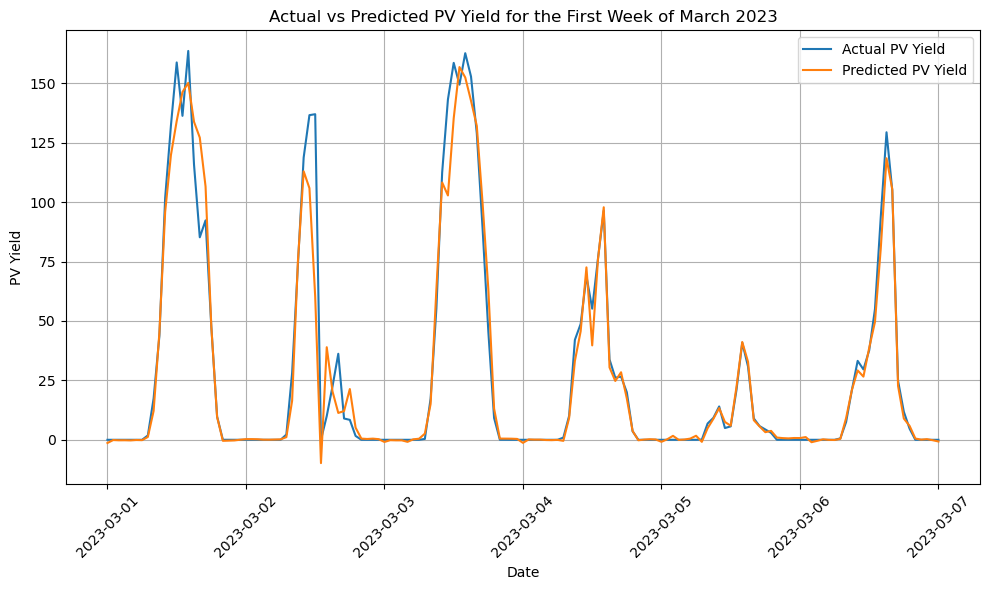

Metrics for the First Week of March 2023:
Mean Squared Error (MSE): 109.85800975080389
Mean Absolute Error (MAE): 4.383487340580389
R-squared (R²) Score: 0.9490651538405667
Root Mean Squared Error (RMSE): 10.48131717632874
Mean Absolute Percentage Error (MAPE) for the First Week of March 2023: 4.561939402404902


In [77]:
# Filter dataset for the first week of March 2023
first_week_march_2023_data = dataset2[(dataset2['Timestamp'] >= '2023-03-01') & (dataset2['Timestamp'] <= '2023-03-07')]

# Get the corresponding indices for the first week of March 2023 data
first_week_march_2023_indices = first_week_march_2023_data.index

actual_first_week_march_2023_yield = first_week_march_2023_data['PV yield counter'].values

predicted_first_week_march_2023_yield = pred_whole_orig[first_week_march_2023_indices]

plt.figure(figsize=(10, 6))
plt.plot(first_week_march_2023_data['Timestamp'], actual_first_week_march_2023_yield, label='Actual PV Yield', )
plt.plot(first_week_march_2023_data['Timestamp'], predicted_first_week_march_2023_yield, label='Predicted PV Yield', )
plt.xlabel('Date')
plt.ylabel('PV Yield')
plt.title('Actual vs Predicted PV Yield for the First Week of March 2023')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mse_first_week_march_2023 = mean_squared_error(actual_first_week_march_2023_yield, predicted_first_week_march_2023_yield)

mae_first_week_march_2023 = mean_absolute_error(actual_first_week_march_2023_yield, predicted_first_week_march_2023_yield)

r2_first_week_march_2023 = r2_score(actual_first_week_march_2023_yield, predicted_first_week_march_2023_yield)

rmse_first_week_march_2023 = np.sqrt(mse_first_week_march_2023)

print("Metrics for the First Week of March 2023:")
print("Mean Squared Error (MSE):", mse_first_week_march_2023)
print("Mean Absolute Error (MAE):", mae_first_week_march_2023)
print("R-squared (R²) Score:", r2_first_week_march_2023)
print("Root Mean Squared Error (RMSE):", rmse_first_week_march_2023)
average_actual_first_week_march_2023_yield = np.mean(actual_first_week_march_2023_yield)
average_predicted_first_week_march_2023_yield = np.mean(predicted_first_week_march_2023_yield)
mape_first_week_march_2023 = np.abs((average_actual_first_week_march_2023_yield - average_predicted_first_week_march_2023_yield) / average_actual_first_week_march_2023_yield) * 100

print("Mean Absolute Percentage Error (MAPE) for the First Week of March 2023:", mape_first_week_march_2023)



1/1 [==============================] - 0s 44ms/step


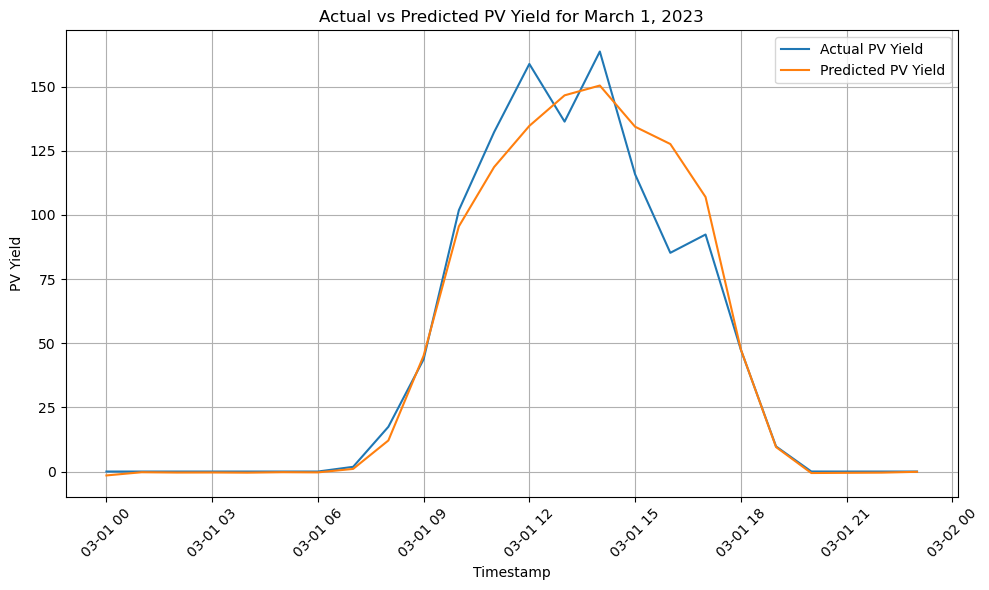

Metrics for March 1, 2023:
Mean Absolute Error (MAE): 6.506723480463029
Mean Squared Error (MSE): 144.8706529827483
Root Mean Squared Error (RMSE): 12.036222537937237
R-squared (R²) Score: 0.9571837721454061
Mean Absolute Percentage Error (MAPE): 1.660419214696528


In [70]:
# Filter dataset for March 1, 2023
first_day_march_data = dataset2[dataset2['Timestamp'].dt.date == pd.Timestamp('2023-03-01').date()]

# Extract features (excluding 'Timestamp') and target variable for the first day of March 2023
X_first_day_march = first_day_march_data.drop(columns=['Timestamp', 'PV yield counter']).values
y_first_day_march = first_day_march_data['PV yield counter'].values

# Scale features for prediction
X_first_day_march_scaled = sc_X.transform(X_first_day_march)
predicted_first_day_march_yield = spfnet.predict(X_first_day_march_scaled)
predicted_first_day_march_yield_orig = sc_y.inverse_transform(predicted_first_day_march_yield)

plt.figure(figsize=(10, 6))
plt.plot(first_day_march_data['Timestamp'], y_first_day_march, label='Actual PV Yield')
plt.plot(first_day_march_data['Timestamp'], predicted_first_day_march_yield_orig, label='Predicted PV Yield')
plt.xlabel('Timestamp')
plt.ylabel('PV Yield')
plt.title('Actual vs Predicted PV Yield for March 1, 2023')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mse_first_day_march = mean_squared_error(y_first_day_march, predicted_first_day_march_yield_orig)

mae_first_day_march = mean_absolute_error(y_first_day_march, predicted_first_day_march_yield_orig)

r2_first_day_march = r2_score(y_first_day_march, predicted_first_day_march_yield_orig)

rmse_first_day_march = np.sqrt(mse_first_day_march)

average_y_first_day_march_actual = np.mean(y_first_day_march)
average_y_first_day_march_pred = np.mean(predicted_first_day_march_yield_orig)
mape_first_day_march = np.abs((average_y_first_day_march_actual - average_y_first_day_march_pred) / average_y_first_day_march_actual) * 100

print("Metrics for March 1, 2023:")
print("Mean Absolute Error (MAE):", mae_first_day_march)
print("Mean Squared Error (MSE):", mse_first_day_march)
print("Root Mean Squared Error (RMSE):", rmse_first_day_march)
print("R-squared (R²) Score:", r2_first_day_march)
print("Mean Absolute Percentage Error (MAPE):", mape_first_day_march)


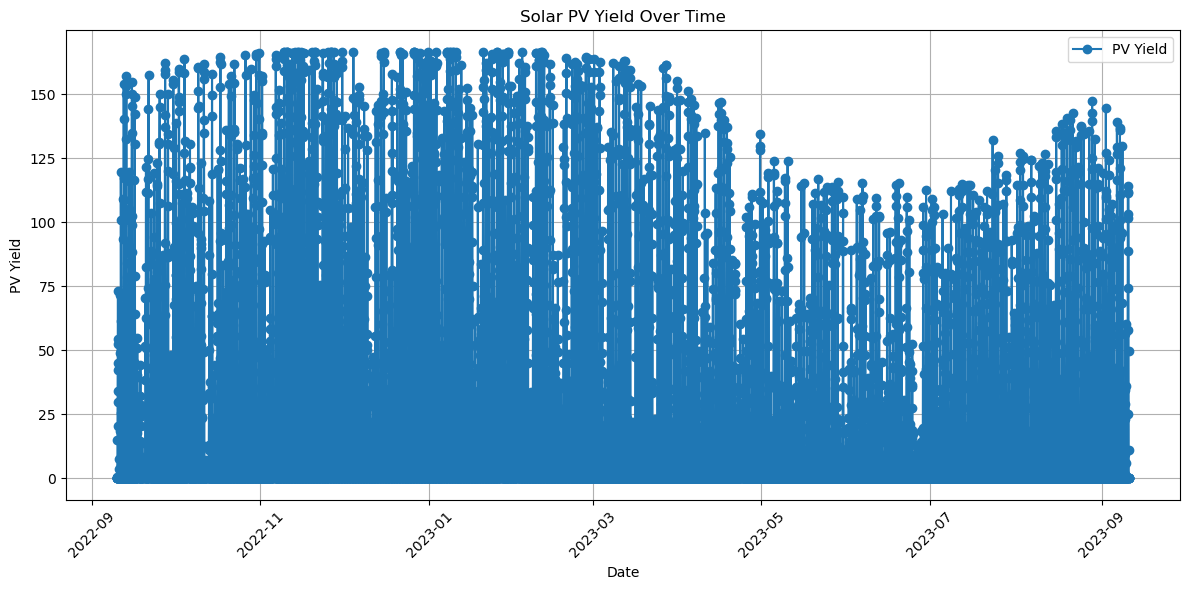

In [53]:
plt.figure(figsize=(12, 6))
plt.plot(dataset2['Timestamp'], dataset2['PV yield counter'], label='PV Yield', marker='o')
plt.xlabel('Date')
plt.ylabel('PV Yield')
plt.title('Solar PV Yield Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


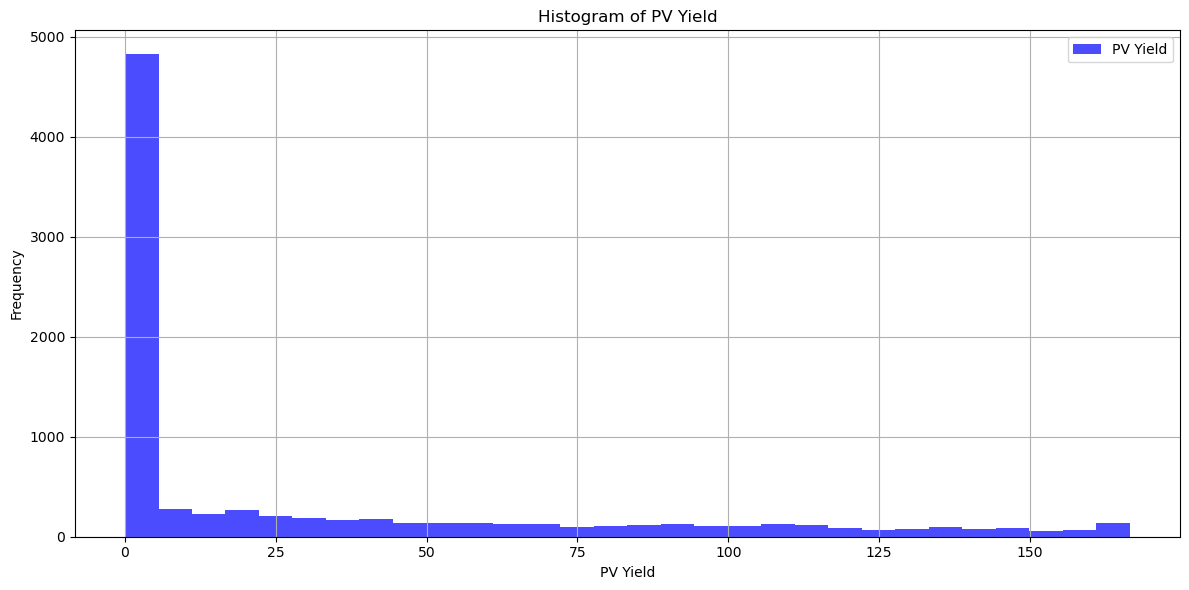

In [44]:
plt.figure(figsize=(12, 6))
plt.hist(dataset2['PV yield counter'], bins=30, alpha=0.7, color='b', label='PV Yield')
plt.xlabel('PV Yield')
plt.ylabel('Frequency')
plt.title('Histogram of PV Yield')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
